In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

**general informations about our data set**

In [2]:
# read the data
data = pd.read_csv("../data/thyroidDF.csv")

In [3]:
# get some information on the data
print("raw data description:\n" , data.describe())
data.dtypes
data.head(5)
print("raw data shape:" , data.shape)
print("raw data NaN:\n", data.isna().sum(axis=0))
print("raw data target:\n",data['target'].value_counts())
data_comp = data.dropna()
print("raw data dropna:", data_comp.shape)
print("raw data duplicates", data.duplicated().sum())

raw data description:
                 age          TSH           T3          TT4          T4U  \
count   9172.000000  8330.000000  6568.000000  8730.000000  8363.000000   
mean      73.555822     5.218403     1.970629   108.700305     0.976056   
std     1183.976718    24.184006     0.887579    37.522670     0.200360   
min        1.000000     0.005000     0.050000     2.000000     0.170000   
25%       37.000000     0.460000     1.500000    87.000000     0.860000   
50%       55.000000     1.400000     1.900000   104.000000     0.960000   
75%       68.000000     2.700000     2.300000   126.000000     1.065000   
max    65526.000000   530.000000    18.000000   600.000000     2.330000   

               FTI         TBG    patient_id  
count  8370.000000  349.000000  9.172000e+03  
mean    113.640746   29.870057  8.529473e+08  
std      41.551650   21.080504  7.581969e+06  
min       1.400000    0.100000  8.408010e+08  
25%      93.000000   21.000000  8.504090e+08  
50%     109.000000 

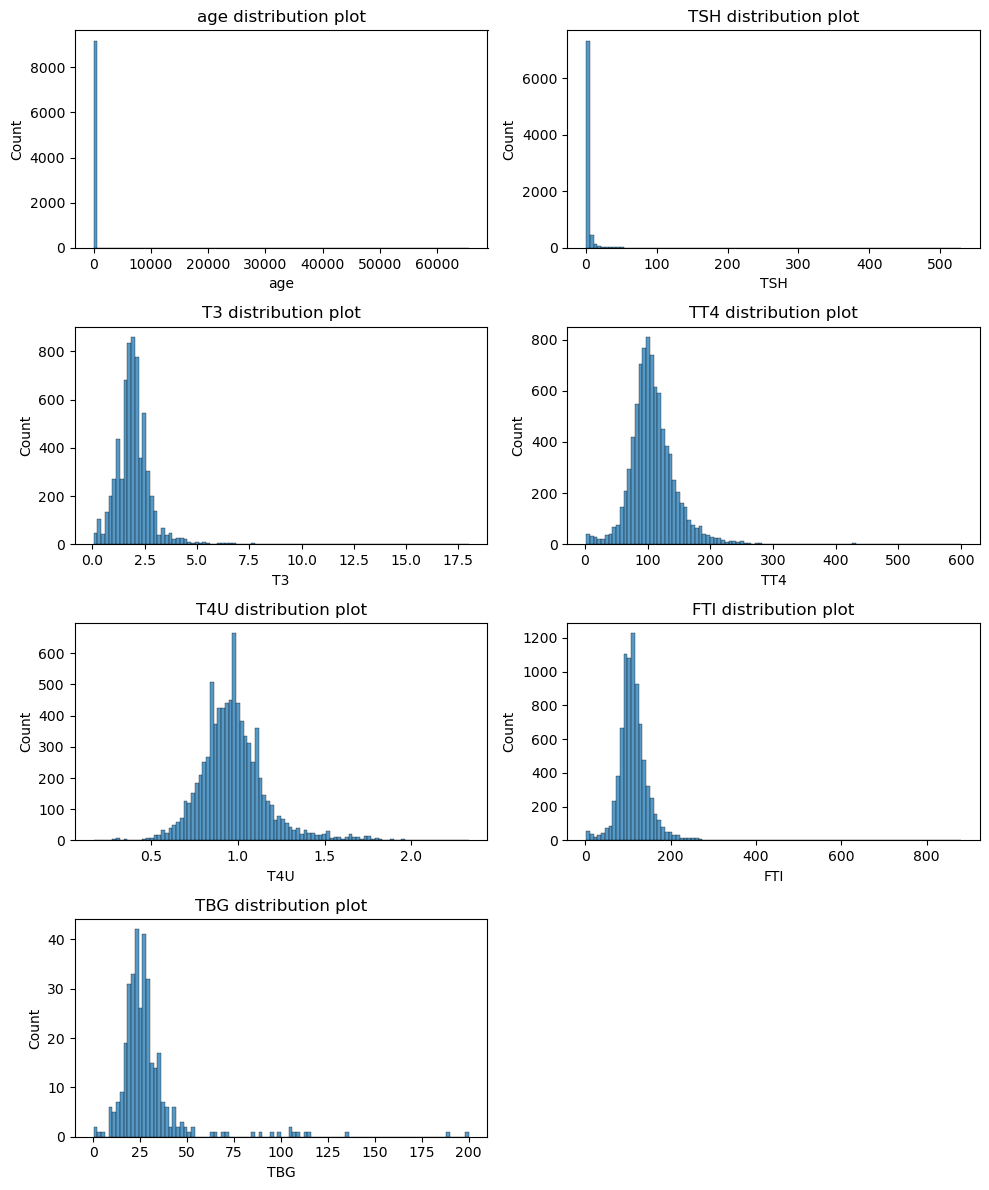

In [4]:
# Distribution plot before cleaning
numerical_columns = data.select_dtypes(include=['int', 'float']).columns
numerical_columns = [col for col in numerical_columns if col != 'patient_id']
num_plots = len(numerical_columns)
num_rows = (num_plots + 1) // 2  # Calculate the number of rows
fig, axs = plt.subplots(4, 2, figsize=(10,12))
for i, column in enumerate(numerical_columns):
    row = i // 2
    col = i % 2
    sns.histplot(data[column], ax=axs[row, col], bins=100)
    axs[row, col].set_title(f'{column} distribution plot')
if num_plots % 2 == 1:
    fig.delaxes(axs[-1, -1])
plt.tight_layout()
plt.show()

In [5]:
#replace values above the threshold with the most frequent value
thresholds = {
    'age': 110,
    'TSH': 20,
    'T3': 10,
    'TT4': 320,
    'T4U': 1000,
    'FTI': 400,
    'TBG': 50
}
# Iterate over columns and thresholds
for column, threshold in thresholds.items():
    # Calculate the most frequent value in the column
    most_frequent_value = data[column].mode()[0]
    # Create a boolean mask to identify values above the threshold
    mask = data[column] > threshold
    # Replace values above the threshold with the most frequent value
    data.loc[mask, column] = most_frequent_value

In [6]:
data = data.drop_duplicates('patient_id')

In [7]:
# Select only numerical columns for imputation
data_numerical = data[numerical_columns]

# Perform most_frequent imputation on numerical data only
imputer = SimpleImputer(strategy='most_frequent')
data_imputed_numerical = pd.DataFrame(imputer.fit_transform(data_numerical), columns=data_numerical.columns)

# Replace original numerical columns with imputed values
data[numerical_columns] = data_imputed_numerical

In [8]:
# For missing sex values
# Calculate the ratio of males to females
male_count = data[data["sex"] == "M"].shape[0]
female_count = data[data["sex"] == "F"].shape[0]
ratio = male_count / female_count
# Fill in missing sex values with the ratio applied to the missing values
missing_sex_count = data["sex"].isnull().sum()
missing_male_count = int(round(missing_sex_count / (ratio + 1)))
missing_female_count = missing_sex_count - missing_male_count

data.loc[data["sex"].isnull(), "sex"] = ["M"] * missing_male_count + ["F"] * missing_female_count

In [9]:
#summarise the diferent targets into groups
data.loc[(data['target'] == 'A') | (data['target'] == 'B') | (data['target'] == 'C') | (data['target'] == 'AK') | (data['target'] == 'D'), 'target'] = '1 - hyperthyroid conditions'
data.loc[(data['target'] == 'E') | (data['target'] == 'F') | (data['target'] == 'FK') | (data['target'] == 'G') | (data['target'] == 'GI') | (data['target'] == 'GK') | (data['target'] == 'GKJ'), 'target'] = '2 - hypothyroid conditions'
data.loc[(data['target'] == 'I') | (data['target'] == 'J') | (data['target'] == 'C|I'), 'target'] = '3 - binding protein'
data.loc[(data['target'] == 'K') | (data['target'] == 'KJ') | (data['target'] == 'H|K'), 'target'] = '4 - general health'
data.loc[(data['target'] == 'L') | (data['target'] == 'M') | (data['target'] == 'MK') | (data['target'] == 'N') | (data['target'] == 'MI') | (data['target'] == 'LJ'), 'target'] = '5 - replacement therapy'
data.loc[(data['target'] == 'O') | (data['target'] == 'P') | (data['target'] == 'Q') | (data['target'] == 'OI'), 'target'] = '6 - antithyroid treatment'
data.loc[(data['target'] == 'R') | (data['target'] == 'S') | (data['target'] == 'T') | (data['target'] == 'D|R'), 'target'] = '7 - miscellaneous'

In [10]:
data['target'].unique

<bound method Series.unique of 0                         -
1                         -
2                         -
3                         -
4         7 - miscellaneous
               ...         
9167                      -
9168                      -
9169    3 - binding protein
9170                      -
9171                      -
Name: target, Length: 9172, dtype: object>

In [11]:
#delete TBG --> too many missing values
#data = data.drop(data['TBG'], axis=0) --> doesn't work

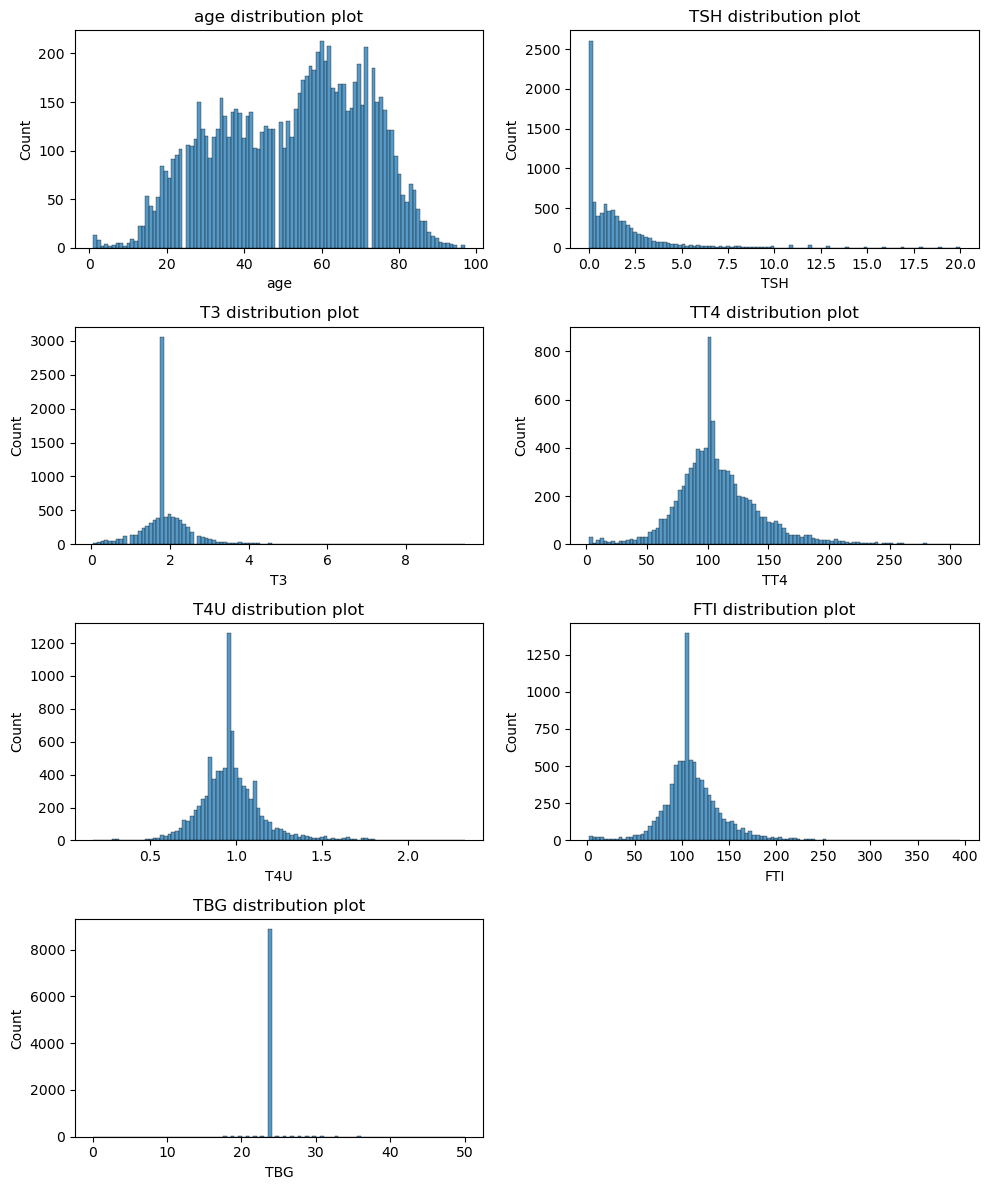

In [12]:
# Distribution plots after cleaning
numerical_columns = data.select_dtypes(include=['int', 'float']).columns
numerical_columns = [col for col in numerical_columns if col != 'patient_id']
num_plots = len(numerical_columns)
num_rows = (num_plots + 1) // 2  # Calculate the number of rows
fig, axs = plt.subplots(4, 2, figsize=(10,12))
for i, column in enumerate(numerical_columns):
    row = i // 2
    col = i % 2
    sns.histplot(data[column], ax=axs[row, col], bins=100)
    axs[row, col].set_title(f'{column} distribution plot')
if num_plots % 2 == 1:
    fig.delaxes(axs[-1, -1])
plt.tight_layout()
plt.show()

In [13]:
# get some information on the data after cleaning
print("cleared data description:\n" , data.describe())
data.dtypes
data.head(5)
print("cleared data shape:" , data.shape)
print("cleared data NaN\n:", data.isna().sum(axis=0))
print("cleared data target\n:",data['target'].value_counts())
data_comp = data.dropna()
print("cleared data dropna:", data_comp.shape)

cleared data description:
                age          TSH           T3          TT4          T4U  \
count  9172.000000  9172.000000  9172.000000  9172.000000  9172.000000   
mean     52.103140     1.824825     1.918206   107.949374     0.974640   
std      18.906892     2.620269     0.720768    34.965282     0.191373   
min       1.000000     0.005000     0.050000     2.000000     0.170000   
25%      37.000000     0.150000     1.700000    88.000000     0.870000   
50%      55.000000     1.100000     1.800000   102.000000     0.960000   
75%      67.000000     2.200000     2.100000   124.000000     1.050000   
max      97.000000    20.000000     9.500000   308.000000     2.330000   

               FTI          TBG    patient_id  
count  9172.000000  9172.000000  9.172000e+03  
mean    112.296014    24.059382  8.529473e+08  
std      34.660738     1.554528  7.581969e+06  
min       1.400000     0.100000  8.408010e+08  
25%      95.000000    24.000000  8.504090e+08  
50%     107.000000

**plots to get familiar with the data**

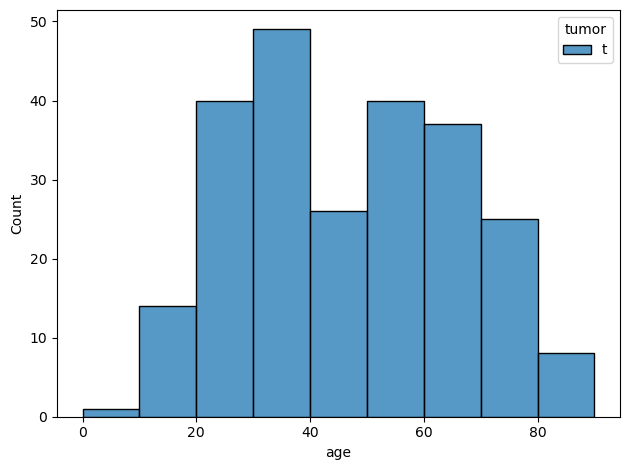

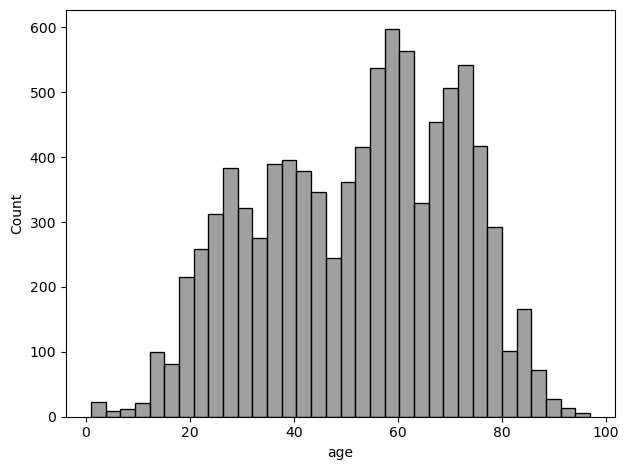

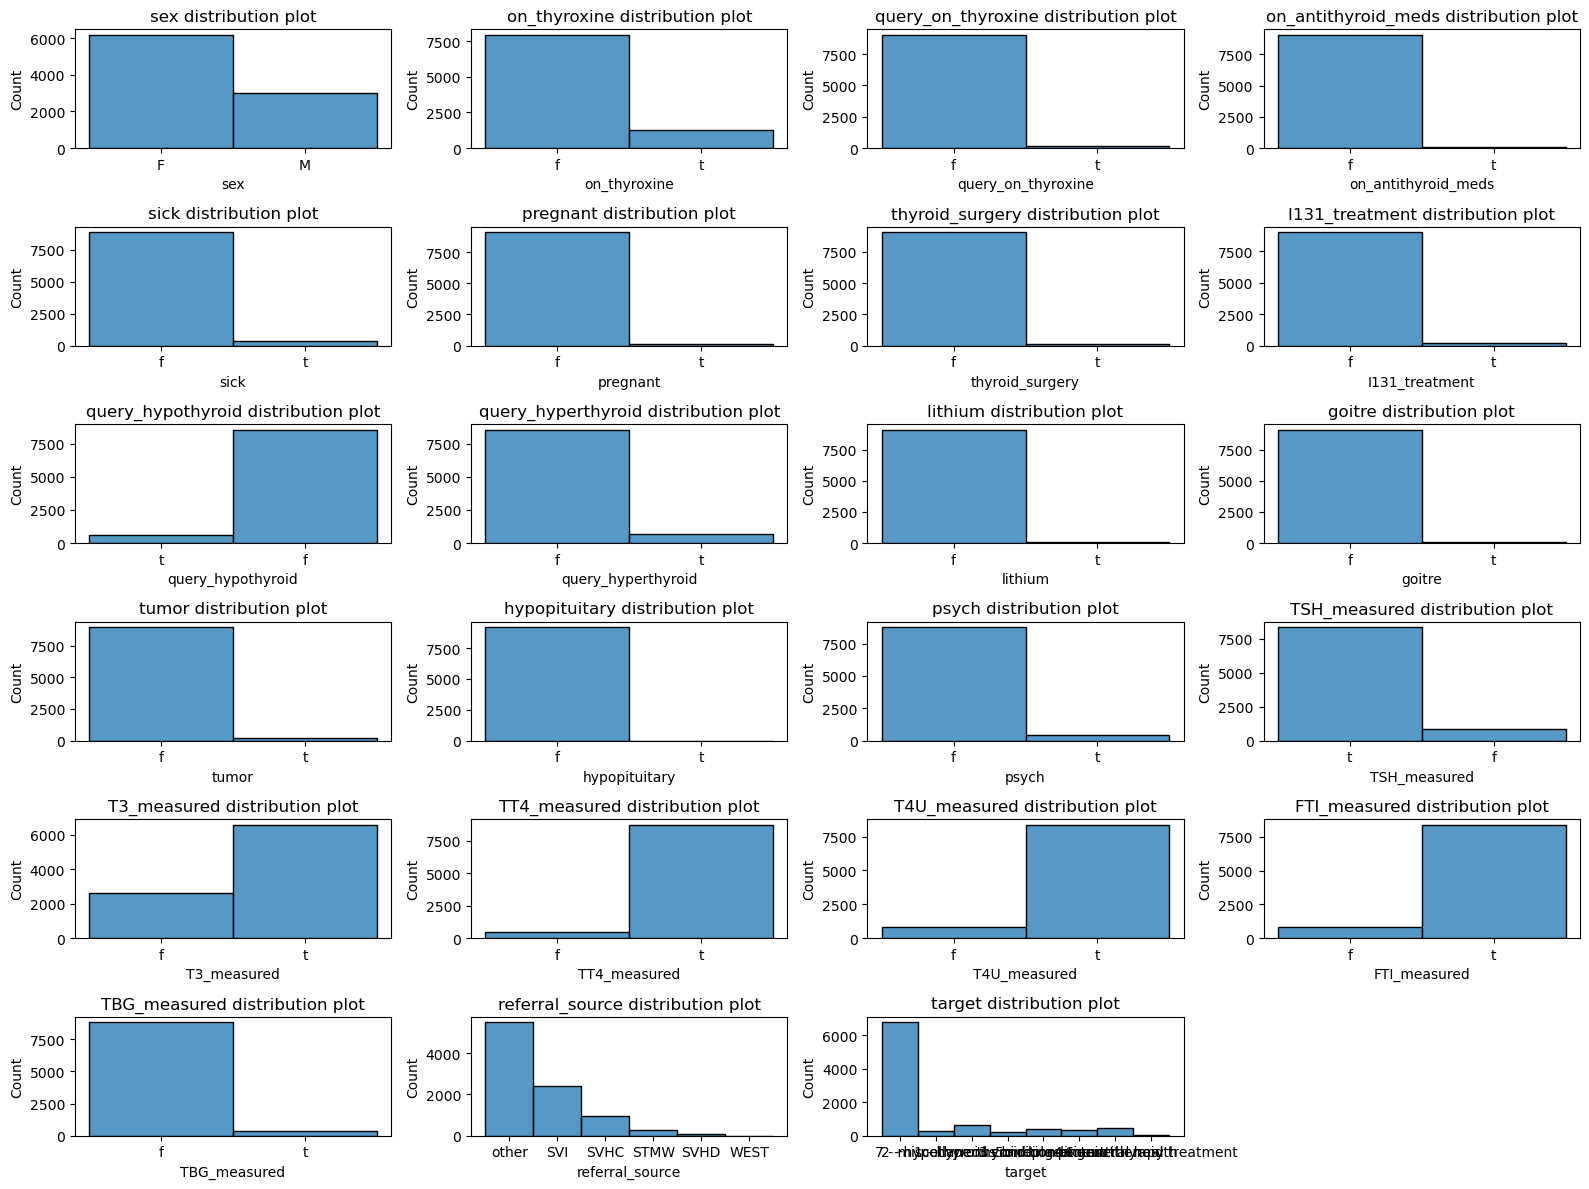

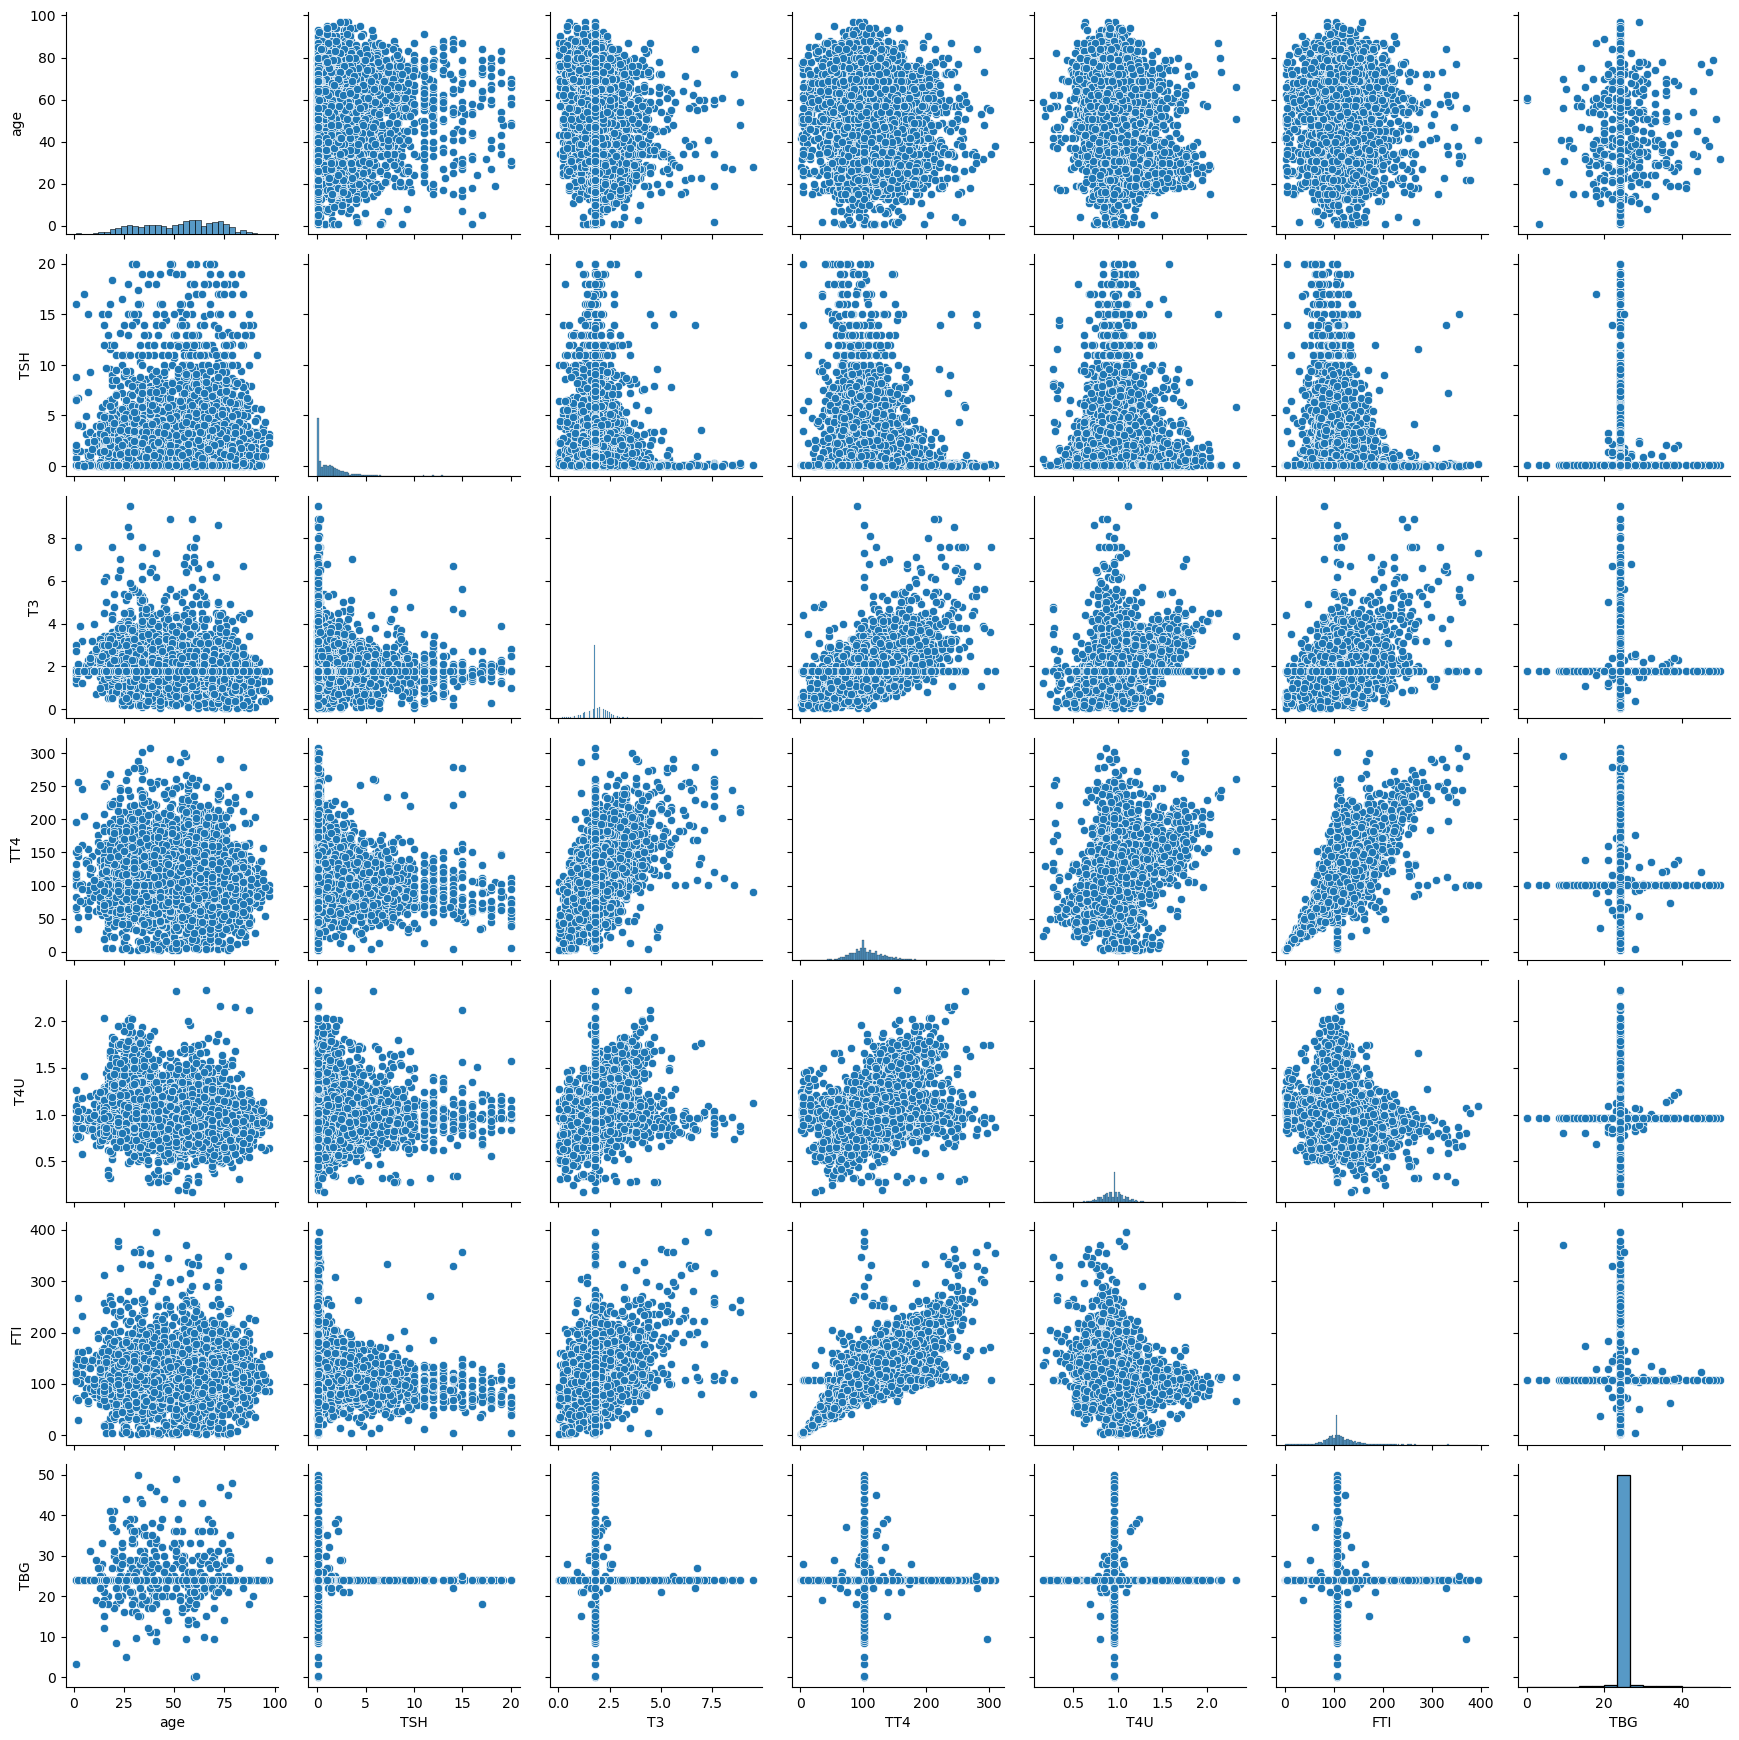

In [14]:
# some plots to get familiar with the data
data_with_tumor = data[data['tumor'] == 't']
sns.histplot(data=data_with_tumor, x='age', bins=range(0, 100, 10), hue='tumor', multiple='stack')
plt.tight_layout()
plt.show()

# age distribution
sns.histplot(data=data, x="age", color="gray")
plt.tight_layout()
plt.show()

#distribution plots
binary_columns = data.select_dtypes(include=['object']).columns
bin_plots = len(binary_columns)
bin_rows = (bin_plots + 3) // 4  # Calculate the number of rows for 4 columns

fig, axs = plt.subplots(bin_rows, 4, figsize=(16, 12))  # Increase figsize and set 4 columns

for i, column in enumerate(binary_columns):
    row = i // 4  # Adjust for 4 columns
    col = i % 4  # Adjust for 4 columns
    sns.histplot(data[column], ax=axs[row, col])
    axs[row, col].set_title(f'{column} distribution plot')

if bin_plots % 4 != 0:
    # Remove empty subplots
    for i in range(bin_plots % 4, 4):
        fig.delaxes(axs[-1, i])

plt.tight_layout()
plt.show()

vars = [col for col in data.columns if data[col].dtype == 'float64' and col != 'patient_id']
pplot = sns.pairplot(data=data,x_vars=vars, y_vars=vars,)
plt.tight_layout()
plt.show()

In [15]:
data.shape

(9172, 31)

**decision tree**

In [ ]:
df = data

In [ ]:
# One-hot encode 'sex' column
df = pd.get_dummies(df, columns=['sex'])
# Loop through all columns with binary values and one-hot encode them
for col in df.columns:
    if df[col].dtype == 'object' and set(df[col].unique()) == {'t', 'f'}:
        df[col] = df[col].apply(lambda x: 1 if x == 't' else 0)
        df = pd.get_dummies(df, columns=[col])
# Print the updated dataframe
print(df.head())


In [ ]:
# Split the dataset into training and testing sets
X = df[['age', 'sex_F', 'sex_M', 'on_thyroxine_1', 'on_thyroxine_0', 'query_hyperthyroid_1',
        'query_hyperthyroid_0', 'query_hypothyroid_1', 'query_hypothyroid_0', 'pregnant_1',
        'pregnant_0', 'thyroid_surgery_1', 'thyroid_surgery_0', 'I131_treatment_1',
        'I131_treatment_0', 'query_on_thyroxine_1', 'query_on_thyroxine_0', 'on_antithyroid_meds_1',
        'on_antithyroid_meds_0', 'sick_1', 'sick_0', 'tumor_1', 'tumor_0', 'lithium_1', 'lithium_0',
        'goitre_1', 'goitre_0', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']]  # Features

#X = df.drop(['target', 'patient_id', 'referral_source'], axis=1)
y = df['target']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standard Scaler
sc = StandardScaler()
X_train_scale = sc.fit_transform(X_train)
X_test_scale = sc.transform(X_test)

In [ ]:
# Define and train the decision tree model
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_scale, y_train)

In [ ]:
# Make predictions on the testing set and evaluate the model performance
y_pred = dt.predict(X_test_scale)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

In [ ]:
print('\nClassification Report:\n', classification_report(y_test, y_pred))

In [ ]:
# Plots
# Feature Importance Plot
feature_importances = pd.DataFrame(dt.feature_importances_, index=X_train.columns, columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
top_15_features = feature_importances.head(15)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y=top_15_features.index, data=top_15_features, palette='gray')
plt.title('Top 15 Decision Tree Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

**random forest**

In [ ]:
# Create a list of the feature columns
feature_cols = ['age', 'sex_F', 'sex_M', 'on_thyroxine_1', 'on_thyroxine_0', 'query_hyperthyroid_1',
                'query_hyperthyroid_0', 'query_hypothyroid_1', 'query_hypothyroid_0', 'pregnant_1',
                'pregnant_0', 'thyroid_surgery_1', 'thyroid_surgery_0', 'I131_treatment_1',
                'I131_treatment_0', 'query_on_thyroxine_1', 'query_on_thyroxine_0', 'on_antithyroid_meds_1',
                'on_antithyroid_meds_0', 'sick_1', 'sick_0', 'tumor_1', 'tumor_0', 'lithium_1', 'lithium_0',
                'goitre_1', 'goitre_0', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']

In [ ]:
#Create a dataframe of the feature data
X = df[feature_cols]

# Create a series of the target variable
y = df['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaler
sc = StandardScaler()
X_train_scale = sc.fit_transform(X_train)
X_test_scale = sc.transform(X_test)

In [ ]:
# Create a random forest classifier object with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Fit the model to the training data
rf.fit(X_train_scale, y_train)

# Use the model to make predictions on the test data
y_pred = rf.predict(X_test_scale)

In [ ]:
# Calculate the accuracy score of the model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.6f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y=top_15_features.index, data=top_15_features, palette='gray')
plt.title('Top 15 Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [ ]:
# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RF: Confusion Matrix')
plt.tight_layout()
plt.show()

**SVM for multiclass**

In [ ]:
# extract the predictor variables and the target variable
X = df.drop(['target', 'patient_id'], axis=1)
y = df['target']

In [ ]:
# encode categorical variables
# get a list of columns where the data type is object
object_cols = list(X.select_dtypes(include=['object']).columns)
# perform one-hot encoding on categorical variables
X = pd.get_dummies(X, columns=object_cols)

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scale the sets
sc = StandardScaler()
X_train_scale = sc.fit_transform(X_train)
X_test_scale = sc.transform(X_test)

In [ ]:
# create the SVM model
model = SVC(class_weight='balanced', random_state=42)

# fit the model to the training data
model.fit(X_train_scale, y_train)

# make predictions on the test data
y_pred = model.predict(X_test_scale)

In [ ]:
# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division = 1)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='micro')

In [ ]:
print("Performance of the multiclass SVM model:")
print("Accuracy: {:.3f}; Precision: {:.3f}; Recall: {:.3f}; F1 score: {:.3f}".format(accuracy, precision, recall, f1))

In [ ]:
#Visualization of SVM
#feature importance
# Compute permutation importances
perm_importance = permutation_importance(model, X_test_scale, y_test, n_repeats=10, random_state=42)
feature_importance = perm_importance.importances_mean
feature_names = X.columns

# Create a DataFrame to store the importances and feature names
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_df = feature_df.sort_values('Importance', ascending=False)

# Get the top 10 features with highest importances
top_features = feature_df.head(10)

# Get the bottom 10 features with lowest importances
bottom_features = feature_df.tail(10)

# Print the top 10 features
print("Top 10 features:")
print(top_features)

In [ ]:
# Print the bottom 10 features
print("Bottom 10 features:")
print(bottom_features)

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Multiclass SVM: Top 10 Features')
plt.tight_layout()
plt.savefig('../output/SVM_feature_selection_multiclass.png', dpi = 600)
plt.clf()

**logistic regression**

In [ ]:
# only go for thyroid disease or no thyroid disease
data.loc[(data['target'] == '1 - hyperthyroid conditions') | (data['target'] == '2 - hypothyroid conditions'), 'target'] = '+'
data.loc[(data['target'] == '3 - binding protein') | (data['target'] == '4 - general health') |
         (data['target'] == '5 - replacement therapy') | (data['target'] == '6 - antithyroid treatment') |
         (data['target'] == '7 - miscellaneous'), 'target'] = '-'
dava = data['target'].value_counts()
print(dava)

In [ ]:
### one-hot encoding ###
# one-hot encoding to make all values numerical
cols_with_letters = data.select_dtypes(include=['object']).columns.tolist()
# Exclude the target column from the list of columns to encode
cols_to_encode = [col for col in cols_with_letters if col != 'target' and col != 'referal_source']

#activate pd.get_dummies for one hot encoding!

#data = pd.get_dummies(data, columns=cols_to_encode)
#data.head(5)

In [ ]:
# choose the columns to scale?
cols_to_scale = [col for col in data.columns if col != 'patient_id' and data[col].dtype != 'object' and col != 'TBG']


In [ ]:
### only using numerica features ###
# Exclude any columns with only 2 unique values (binary columns)
continuous_cols = [col for col in cols_to_scale if len(data[col].unique()) > 2]

In [ ]:
### Binary encoding for binary objects ###
# Identify binary object features
binary_cols = [col for col in cols_with_letters if col != 'target' and col != 'referal_source'
               and len(data[col].unique()) == 2]

# Apply binary encoding for binary object features
for col in binary_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

selected_cols = binary_cols + cols_to_scale

In [ ]:
# Select the continuous columns from the DataFrame
#1. Only using the numerical features:  choose X=data[contimuous_cols]
#2. One-hot encoding:                   choose X=data[cols_to_scale] & activate pd.get_dummies
#3. Binary encoding for binary objects: choose X=data[selected_cols]
X = data[selected_cols]
# Select your target variable
y = data['target']

In [ ]:
print(X)

In [ ]:
# Perform feature selection using correlation-based method
selector = SelectKBest(score_func=f_classif, k=6)  # Select the top k features
X_selected = selector.fit_transform(X, y)

In [ ]:
#Für feature selection X = X_selected!
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)
# Fit the logistic regression model
sc = StandardScaler()
tr_scale = sc.fit_transform(X_train)
print(tr_scale.shape)

In [ ]:
te_scale = sc.transform(X_test)
lr = LogisticRegression(class_weight='balanced', random_state= 42)
lr.fit(tr_scale, y_train)

In [ ]:
# Make predictions on the test set
y_pred = lr.predict(te_scale)
print(te_scale.shape)

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

In [ ]:
print('\nClassification Report:\n', classification_report(y_test, y_pred))

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig, ax = plt.subplots()
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = conf_mat[[1, 0], :][:, [1, 0]]
conf_plt = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax = ax)
conf_plt.set(title = 'Confusion Matrix Logistic Regression',
             ylabel = 'True label',
             xlabel = 'Predicted label')

plt.tight_layout()
plt.savefig('../output/conf_martrix.png', dpi = 600)


In [ ]:
# Fit the SelectKBest feature selector
selector = SelectKBest(score_func=f_classif, k=6)
selector.fit(X, y)

# Get the scores and corresponding feature names
feature_scores = selector.scores_
feature_names = X.columns

# Sort the feature scores and names in descending order
sorted_indices = np.argsort(feature_scores)[::-1]
sorted_scores = feature_scores[sorted_indices]
sorted_names = feature_names[sorted_indices]

# Select only the top 10 features
top_scores = sorted_scores[:6]
top_names = sorted_names[:6]

# Plot the feature selection
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_scores)), top_scores, align='center')
plt.yticks(range(len(top_scores)), top_names)
plt.xlabel('Coefficient Magnitude', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.title('Top 6 Feature Selection', fontsize = 15)
plt.tight_layout()
plt.savefig('../output/LR_feature_selection.png', dpi = 600)


In [ ]:
'''# Feature Importance Plot

# Get the absolute coefficient values
coefficients = np.abs(lr.coef_.ravel())
# Get the indices of the top 10 features
top_feature_indices = np.argsort(coefficients)[-6:]

# Get the top feature names
top_feature_names = X_train.columns[top_feature_indices]
# Get the corresponding coefficient values
top_coefficients = coefficients[top_feature_indices]
# Sort the features and coefficients in descending order
top_feature_names = top_feature_names[::-1]
top_coefficients = top_coefficients[::-1]
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_coefficients, align='center')
plt.xlabel('Coefficient Magnitude', fontsize = 15)
plt.ylabel('Features', fontsize = 15)
plt.title('Feature selection', fontsize = 15)
plt.tight_layout()
#plt.show()
plt.savefig('../output/LR_feature_selection.png', dpi = 600)'''

**5 fold cross-validation**

In [ ]:
# Select the continuous columns from the DataFrame
#1. Only using the numerical features:  choose X=data[continuous_cols]
#2. One-hot encoding:                   choose X=data[cols_to_scale] & activate pd.get_dummies
#3. Binary encoding for binary objects: choose X=data[selected_cols]
X = data[cols_to_scale]
# Select your target variable
y = data['target']

# Standardize the features
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Create the logistic regression model
lr = LogisticRegression(class_weight='balanced', random_state=42)

# Perform 5-fold cross-validation and get the predictions
y_pred = cross_val_predict(lr, X_scaled, y, cv=5)
scores = cross_val_score(lr, X_scaled, y, cv=5)

# Generate the classification report
report = classification_report(y, y_pred)

# Print the classification report
print("Classification Report:\n", report)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())
print('')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit the logistic regression model on the training data
lr.fit(X_train, y_train)

# Get the predictions on the test set
y_pred_test = lr.predict(X_test)

# Calculate and print the evaluation metrics on the test set
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_test, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_test, average='weighted'))

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", cm)
fig, ax = plt.subplots()
conf_mat = confusion_matrix(y, y_pred)
conf_plt = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', ax = ax)
conf_plt.set(title = 'Confusion matrix 5fcv',
             ylabel = 'True label',
             xlabel = 'Predicted label')

plt.tight_layout()
plt.show()

**SVM for binary**

In [ ]:
# extract the predictor variables and the target variable
X = df.drop(['target', 'patient_id'], axis=1)
y = df['target']

In [ ]:
# encode categorical variables
# get a list of columns where the data type is object
object_cols = list(X.select_dtypes(include=['object']).columns)
# perform one-hot encoding on categorical variables
X = pd.get_dummies(X, columns=object_cols)

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#scale the sets

sc = StandardScaler()
X_train_scale = sc.fit_transform(X_train)
X_test_scale = sc.transform(X_test)

In [ ]:
# create the SVM model
model = SVC(class_weight='balanced', random_state=42)

# fit the model to the training data
model.fit(X_train_scale, y_train)

# make predictions on the test data
y_pred = model.predict(X_test_scale)

In [ ]:
# evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Performance of the binary SVM model:")
print("Accuracy: {:.3f}; Precision: {:.3f}; Recall: {:.3f}; F1 score: {:.3f}".format(accuracy, precision, recall, f1))

In [ ]:
#Visualization of SVM
#feature importance

# Compute permutation importances
perm_importance = permutation_importance(model, X_test_scale, y_test, n_repeats=10, random_state=42)
feature_importance = perm_importance.importances_mean
feature_names = X.columns

# Create a DataFrame to store the importances and feature names
feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_df = feature_df.sort_values('Importance', ascending=False)

# Get the top 10 features with highest importances
top_features = feature_df.head(10)

# Get the bottom 10 features with lowest importances
bottom_features = feature_df.tail(10)

In [ ]:
# Print the top 10 features
print("Top 10 features:")
print(top_features)

In [ ]:
# Print the bottom 10 features
print("Bottom 10 features:")
print(bottom_features)

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.title('Binary SVM: Top 10 Features')
plt.tight_layout()
plt.savefig('../output/SVM_feature_selection_binary.png', dpi = 600)
plt.clf()